# Assignment 10

### 1.复习上课内容

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

In order to reduce the complexity of computation, Naive bayes assumes that all features are independent, which means the probability $P(x_1,x_2,x_3,...,x_n|y)$ can be calculated as $\prod_{i=1}^{n}P(x_{i}|y)$, and these $P(x_i|y)$ are easier to obtain from the dataset.

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

Both of MAP and ML are used to estimate the best parameters for the model, they can be calculated as follows:  
$$\hat{\theta}_{MAP} = {\underset{\theta}{\arg\max}} P(\theta|X) = {\underset{\theta}{\arg\max}} {\frac{P(X|\theta)P(\theta)}{P(X)}}={\underset{\theta}{\arg\max}}{P(X|\theta)P(\theta)}$$
$$\hat{\theta}_{MLE} = {\underset{\theta}{\arg\max}}P(X|\theta) = P(x_1,x_2,...,x_n|\theta) = \prod_{i=1}^{n}P(x_{i}|\theta)$$  
As the MAP's denominator only relates to the data $X$, the difference between them is that MAP added an extra prior($P(\theta)$) to the estimation.

#### 3. What is support vector in SVM?

Support vectors refer to the data points on the hyperplane which is located nearest to the decision boundary, those points are the ones which actually affect the model.

#### 4. What is the intuition behind SVM ?

The intuition behind SVM is to use **kernel tricks** to map the data to a linearly separable form, and find the best decision boundary with the **max margins** via solving the **constrained optimization problem**.

#### 5. Shortly describ what 'random' means in random forest ?

In random forest, each tree will be built based on randomly sampled data using bootstrap method, with a randomly chose feature subset, therefore the trees will not be operating the same process.

#### 6. What criterion does XGBoost use to find the best split point in a tree ?

XGBoost uses the function $Obj = -\frac{1}{2}\sum_{t=1}^T\frac{G_t}{H_t + \lambda}+\gamma T$ as the metric to find the best tree structure, and the criterion to find the best split point is $Gain = \frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{G_L^2+G_R^2}{H_L+H_R+\lambda}-\gamma$, where $G$ and $H$ stands for Gradient and Hessian, $T$ stands for the number of the leaf nodes, and $L$ and $R$ stands for the left part and right part of the split point.

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

### 导入工具包

In [78]:
import numpy as np
import pandas as pd
from joblib import Parallel,delayed # 多进程处理
import time
import jieba
import re

from gensim.models import FastText # 词向量
from gensim.models import doc2vec # 生成文本向量

# from tensorflow.keras.layers import Embedding, Dense, Input, Bidirectional, GRU
# from tensorflow.keras import Model

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

### 读入数据

In [312]:
data = pd.read_csv("新华社数据.csv", encoding="gb18030")

In [313]:
data.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [314]:
data.iloc[25]

id                                                     89592
author                                                   NaN
source                                                   新华网
content    当地时间2017年6月17日，土耳其马尼萨省，在土耳其第1步兵训练大队司令部军营，590名土...
feature    {"type":"国际新闻","site":"环球","commentNum":"0","j...
title                            土耳其近590名士兵疑食物中毒 被送往医院救治（组图）
url        http://world.huanqiu.com/hot/2017-06/10866176....
Name: 25, dtype: object

In [315]:
data.iloc[25].content

'当地时间2017年6月17日，土耳其马尼萨省，在土耳其第1步兵训练大队司令部军营，590名土耳其士兵疑是食物中毒，在晚饭后出现恶心和呕吐症状，被紧急送往医院救治。土耳其警方随后逮捕了19名相关人员，其中包括为军营提供食物的餐饮公司负责人。\r\n来源：新华网\r\n'

In [316]:
# feature中是一些其他属性
data.iloc[25].feature

'{"type":"国际新闻","site":"环球","commentNum":"0","joinNum":"0","clickNum":"0","shareNum":"0","url":"http://world.huanqiu.com/hot/2017-06/10866176.html","site_sign":"huanqiu","label":"","summary":"土耳其近590名士兵疑食物中毒 被送往医院救治（组图）：当地时间2017年6月17日，土耳其马尼萨省，在土耳其第1步兵训练大队司令部军营，590名土耳其士兵疑是食物中毒，在晚饭后出现恶心和呕吐症状，被紧急送往医院救治。当地时间2017年6月17日，土耳其马尼萨省，在土耳其第1步兵训练大队司令部军营，590名土耳其士兵疑是食物中毒，在晚饭后出现恶心和呕吐症状，被紧急送往医院救治。","is_hot":"0","imgUrls":""}'

### 数据预处理

移除明显无用的属性

In [317]:
data.drop(['author', 'url'], axis=1, inplace=True)

检查空值

In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89611 entries, 0 to 89610
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       89611 non-null  int64 
 1   source   89609 non-null  object
 2   content  87054 non-null  object
 3   feature  89611 non-null  object
 4   title    89577 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [319]:
data['content'].isna().sum()

2557

In [320]:
data['source'].isna().sum()

2

除了id和feature列，其他特征均有空值，其中比较重要的content有2557条为空，source有两条为空。

In [321]:
# 查看object类型的特征统计
data.describe(include='O')

,source,content,feature,title
count,89609,87054,89611,89577
unique,974,74917,89184,85253
top,新华社,\n\n,"{""commentNum"":""2"",""forwardNum"":""7"",""playNum"":""...",国际重要稿件预告
freq,78661,177,3,219


In [322]:
data[data['content'] == '\\n\\n'].head()

,id,source,content,feature,title
11315,78297,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",广州青岛调控加码：不动产证满两年方可交易
12294,77318,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",河北雄安新区来了！你想知道的都在这里
15615,73997,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",中国实业转型升级竞逐全球的新“联想”
15880,73732,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",前有深圳、浦东，今天的雄安新区潜力有多大
20022,69590,新华社,\n\n,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",图解丨“垃圾分类”时代来了 你知道怎么分吗？


In [323]:
data[data['content'] == '\\n\\n'].iloc[-1]['feature']

'{"type":"其它","site":"新华社","url":"http://home.xinhua-news.com/gdsdetailxhsnew/2198960-?pageflag=init&imageOrVedioTypeGdsId=","site_sign":"xinhua","keywords":"-","summary":"","rich_label":"[]","all_type":"新媒体,新媒体专线\\r\\n","issuing_department":"","id":"2198960","no":"200012017060601198251","word_count":"0","related_areas":"","reported_area":"","imgUrls":"noImage"}'

数据不均衡，89611条数据中，有78661条是新华社发布的，需要进行下采样或者调整类别权重，避免全部预测为正例还能获得很高的分数。  
有177条数据的content为\n\n，对应的feature中summary也基本为空，使用title进行替换。

In [324]:
def replace_content_with_title(row):
    row.content = row.title
    return row

In [325]:
data[data['content'] == '\\n\\n'] = data[data['content'] == '\\n\\n'].apply(replace_content_with_title, axis=1)

处理空值

In [326]:
data[data['source'].isna()]

,id,source,content,feature,title
4960,84657,NaN,投服中心四问万盛股份\r\n □本报记者 周松林 徐金忠 官平\r\n 6月21日，在...,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",收购匠芯知本拟双主业运行
9997,79620,NaN,????搜狐传媒讯，作为一档非选秀节目，新一季《中国梦想秀》将于4月5日开播，有关赛制和梦想...,"{""type"":""新闻"",""site"":""百度"",""commentNum"":""0"",""joi...",中国梦想秀助梦团-雨轩范文网


从feature中可以看出source为空的数据来源为中证网和百度，直接当做负类处理即可。  

In [327]:
data[data['content'].isna()].head()

,id,source,content,feature,title
100,89517,中国证券报?中证网,NaN,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",天和防务股东未来6个月内计划减持不超过480万股公司股份
103,89514,中国证券报?中证网,NaN,"{""type"":""公司"",""site"":""中证网"",""commentNum"":""0"",""jo...",晶盛机电调整限制性股票回购价格
997,88620,央广网,NaN,"{""type"":""时事要闻"",""site"":""参考消息"",""commentNum"":""0"",...",[主播不在家]第二季：主播陈亮体验垃圾清运
1273,88344,央广网,NaN,"{""type"":""IT业界"",""site"":""参考消息"",""commentNum"":""0"",...",LKK洛可可：想象力经济时代或已到来
1282,88335,央广网,NaN,"{""type"":""IT业界"",""site"":""参考消息"",""commentNum"":""0"",...",CES2017：京东发布两款叮咚智能音箱新品 开放Alpha平台


In [328]:
data[data['content'].isna()].source.unique()

array(['中国证券报?中证网', '央广网', '中国台湾网', '海南日报第016版', '海南日报第015版', '海南日报第013版',
       '海南日报第012版', '海南日报第011版', '海南日报第010版', '郑州日报第11版', '海南日报第009版',
       '海南日报第005版', '海南日报第004版', '南方日报第01版', '海南日报第002版', '中国新闻网',
       '海南日报第001版', '郑州日报第01版', '长江日报第24版', '长江日报第23版', '海南日报第018版',
       '海南日报第017版', '海南日报第014版', '郑州日报第03版', '微博', '知乎'], dtype=object)

可以看到内容为空的记录来源基本都是非新华社，如果全部移除会造成负类数据更为稀少，这里直接使用title进行替换。

In [329]:
data[data['content'].isna()] = data[data['content'].isna()].apply(replace_content_with_title, axis=1)

再次检查空值

In [330]:
data[data['content'].isna()].head()

,id,source,content,feature,title
8165,81452,微博,NaN,"{""commentNum"":""0"",""forwardNum"":""1"",""playNum"":""...",NaN
8223,81394,微博,NaN,"{""commentNum"":""0"",""forwardNum"":""1"",""playNum"":""...",NaN
8236,81381,微博,NaN,"{""commentNum"":""5"",""forwardNum"":""0"",""playNum"":""...",NaN
8358,81259,微博,NaN,"{""commentNum"":""0"",""forwardNum"":""0"",""playNum"":""...",NaN
8476,81141,微博,NaN,"{""commentNum"":""1"",""forwardNum"":""39"",""playNum"":...",NaN


In [331]:
data[data['content'].isna()]['source'].unique()

array(['微博'], dtype=object)

In [332]:
data[data['content'].isna()].iloc[3]['feature']

'{"commentNum":"0","forwardNum":"0","playNum":"0","mid":"4116740957172892","type":"图文","favoriteNum":"0","likeNum":"3"}'

content和title都为空的情况都来自微博，并且feature中的type为图文，对训练没有意义，直接移除

In [333]:
data.drop(data[data['content'].isna()].index, inplace=True)

In [334]:
len(data)

89577

本次需要使用的内容为source和content两列，取出对应内容

In [335]:
data = data[['source','content']]

### 生成标签

In [336]:
def generate_label(source, include_website=False):
    if not source:
        return 0
    if include_website and re.search('新华[社|网]', str(source)):
        return 1
    elif re.search('新华社', str(source)):
        return 1
    else:
        return 0

In [337]:
data.source = data.source.apply(generate_label)

In [338]:
data.columns = ['label', 'content']

In [339]:
data.head()

,label,content
0,0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...
1,0,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...
2,0,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...
3,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n
4,0,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...


### 处理文本内容

In [340]:
# 读取停止词
with open("./stopwords.txt", encoding="utf-8-sig") as f:
    stopwords = [line.strip() for line in f.readlines()]

多进程运行分词函数

In [341]:
def cut_it(content, stopwords=None):
    words = jieba.lcut(content)
    # 过滤停用词
    if stopwords:
        print("here")
        filter_words = [word for word in words if word not in stopwords]
    else:
        filter_words = words
    return " ".join(filter_words)

In [342]:
def clean(data, stopwords):
    data['content'] = data['content'].apply(cut_it, stopwords=stopwords)
    return data

def parallel_apply(data, func, stopwords):
    groups = data.groupby(data.index)
    results = Parallel(n_jobs=4)(delayed(func)(group, stopwords) for n, group in groups)
    return pd.concat(results)

考虑到有些常用词语或口语化的词语可能可以使新闻和娱乐的区分更为明确，没有对停用词进行处理

In [343]:
s = time.time()
data = parallel_apply(data, clean, stopwords=None)
e = time.time()
diff = e - s
print("%.2f seconds cost for word cutting" % diff)

892.6828997135162


In [344]:
data.head()

,label,content
0,0,此外 ， 自 本周 （ 6 月 12 日 ） 起 ， 除 小米 手机 6 等 15 款 机型...
1,0,骁龙 835 作为 唯一 通过 Windows 10 桌面 平台 认证 的 ARM 处理...
2,0,此前 的 一加 3T 搭载 的 是 3400mAh 电池 ， DashCharge 快充 规...
3,1,这是 6 月 18 日 在 葡萄牙 中部 大 佩德罗 冈 地区 拍摄 的 被 森林 大火 烧...
4,0,（ 原 标题 ： 44 岁 女子 跑 深圳 约会 网友 被 拒 ， 暴雨 中 裸身 奔走 …...


保存分词后的数据

In [16]:
data.to_csv("processed_data.csv", index=False)

### 使用doc2vec生成句子向量

使用TaggedDocument准备符合doc2vec所需格式的输入

In [382]:
def tag_documents(data):
    return [doc2vec.TaggedDocument(text.split(" "), [i]) for i, text in enumerate(data)]

In [350]:
documents = tag_documents(data['content'])

训练模型，生成向量

In [373]:
def train_doc2vec(train_data, vector_size=100, epochs=10):
    s = time.time()
    model = doc2vec.Doc2Vec(train_data, min_count=1, vector_size=vector_size, sample=1e-3, negative=5, workers=4)
    m = time.time()
    print("model built in %.2f seconds..." % (m-s))
    model.train(train_data, total_examples=model.corpus_count, epochs=epochs)
    e = time.time()
    print("model trained in %.2f seconds..." % (e-m))
    print("Total time cost: %.2f seconds" % (e-s))
    return model

In [374]:
d2v_model = train_doc2vec(documents)

model built in 780.11 seconds...
model trained in 998.70 seconds...
Total time cost: 1778.81 seconds


100条数据运行13秒，1000条数据运行71秒，10000条数据运行390秒，全部数据1778秒

测试词向量和句子向量

In [377]:
d2v_model.most_similar("此外")

E:\ProgramData\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('与此同时', 0.8007556796073914),
 ('同时', 0.7219498753547668),
 ('除此之外', 0.7020956873893738),
 ('另外', 0.6954978704452515),
 ('不仅如此', 0.6863111257553101),
 ('据悉', 0.6562355756759644),
 ('据介绍', 0.6291040778160095),
 ('不过', 0.5885369777679443),
 ('近年来', 0.5840718746185303),
 ('例如', 0.5708256363868713)]

In [386]:
d2v_model.most_similar("本周")

E:\ProgramData\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('下周', 0.6071938276290894),
 ('近期', 0.5483295917510986),
 ('接下来', 0.5221979022026062),
 ('周一', 0.503481388092041),
 ('今年', 0.49860355257987976),
 ('本轮', 0.49837443232536316),
 ('当天', 0.49752697348594666),
 ('本月', 0.49176257848739624),
 ('周五', 0.49065977334976196),
 ('明年', 0.4871312975883484)]

In [388]:
d2v_model.infer_vector("测试 句子 向量 的 结果。".split(" "))

array([-0.03013344,  0.0311793 ,  0.07500315,  0.03532163, -0.01435754,
        0.02375523, -0.06187371,  0.16740592, -0.02543208, -0.00388691,
       -0.03813968,  0.05223802, -0.01682386,  0.02309733, -0.05332732,
       -0.09471044,  0.00539344, -0.03102777,  0.01740274,  0.07647291,
        0.01871366, -0.05412707,  0.01386418, -0.11117151, -0.01180055,
        0.05680007,  0.00641289,  0.09814149,  0.01581566, -0.06954715,
        0.02853889,  0.03546312,  0.00155082, -0.12295484,  0.03212266,
       -0.01781205,  0.13651372,  0.09579171,  0.04545794, -0.02027204,
       -0.05683808,  0.01273442, -0.02390513,  0.03401305,  0.011106  ,
       -0.16088212, -0.06613839,  0.15077539,  0.10235438,  0.0348312 ,
       -0.03138751, -0.03970571, -0.01169431, -0.0136871 ,  0.0479325 ,
        0.052931  ,  0.17103706,  0.03305549, -0.01771477, -0.03399232,
       -0.0714764 ,  0.03364879,  0.04305898,  0.03807432, -0.00266477,
       -0.04170706, -0.02112675,  0.06557299,  0.06001058,  0.11

保存模型以备后用。

In [396]:
d2v_model.save("doc2vec_model")

读取模型

In [9]:
def load_doc2vec(path="doc2vec_model"):
    model = doc2vec.Doc2Vec.load(path)
    # 如果之后不需要继续训练，可以使用delete_temporary_training_data删除训练相关内容，减少空间占用。
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    return model

### 使用GRU生成句子向量

训练词向量

In [415]:
contents = [content.split(" ") for content in data['content']]

In [422]:
s = time.time()
# w2v_model = word2vec.Word2Vec(contents, size=100, window=5, min_count=1, workers=4)
wv_model = FastText(contents, size=100, window=5, min_count=1, iter=10, workers=4)
e = time.time()
print("model trained in %.2f seconds..." %(e-s))

model trained in 872.60 seconds...


In [424]:
wv_model.most_similar("本周")

E:\ProgramData\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('本周一', 0.7760252356529236),
 ('于本周', 0.7161431312561035),
 ('上周二', 0.6255700588226318),
 ('上周三', 0.6222138404846191),
 ('下周一', 0.6162354946136475),
 ('上周', 0.5951880216598511),
 ('上周四', 0.5885258316993713),
 ('周一', 0.5829751491546631),
 ('本月底', 0.5820356011390686),
 ('本月', 0.5717788934707642)]

保存词向量

In [425]:
wv_model.save("fasttext_model")

构建网络

In [ ]:
# TODO 使用双向GRU进行分类训练，提取GRU最后分类前一层的输出，作为输入传入其他模型
# layer_index=7 # the index of the layer you want to observe
# intermediate_layer_model=Model(inputs=model.input, outputs=model.get_layer(index=layer_index).output)
# intermediate_output = intermediate_layer_model.predict(x)# 承接训练集
# print(intermediate_output.shape)

# intermediate_output1 = intermediate_layer_model.predict(x_test3)# 测试集
# print(intermediate_output1.shape)

# svc(intermediate_output, y0,intermediate_output1, y0_test3) # 接上SVM

### 建立模型，进行分类

In [79]:
class Classifier:
    def __init__(self, model, embed_method="doc2vec"):
        self.model = model
        if embed_method == "doc2vec":
            self.embed_model = load_doc2vec()
        else:
            pass
    
    def infer_vectors(self, X):
        return [self.embed_model.infer_vector(x.split(' ')) for x in X]
    
    def train(self, X, y, **args):
        self.model.fit(X, y, **args)
    
    def predict(self, X, get_prob=False):
        if get_prob:
            return self.model.predict_proba(np.array(X))[:,-1]
        else:
            return self.model.predict(X)
        
    def evaluate(self, X, y):
        return self.model.score(X, y)
    
    def draw_roc_curve(self, X, y):
        y_pred = self.predict(X, get_prob=True)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        return auc(fpr, tpr)

准备数据，划分数据集

In [4]:
data = pd.read_csv("processed_data.csv")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=0.2, random_state=16)

使用SVC建立模型，通过class_weight加大负样本的权重，设置probability=True以使用predict_proba函数（会降低训练速度）

In [7]:
svc = SVC(class_weight={0:0.8, 1:0.2}, probability=True)

In [10]:
classifier = Classifier(svc)

转化数据

In [11]:
X_train_vectors = classifier.infer_vectors(X_train)

In [12]:
X_test_vectors = classifier.infer_vectors(X_test)

模型训练

In [35]:
classifier.train(X_train_vectors, y_train)

E:\ProgramData\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


模型评估

In [36]:
classifier.evaluate(X_train_vectors, y_train)

0.9638715619374555

In [37]:
classifier.evaluate(X_test_vectors, y_test)

0.9622125474436258

0.980723626711204

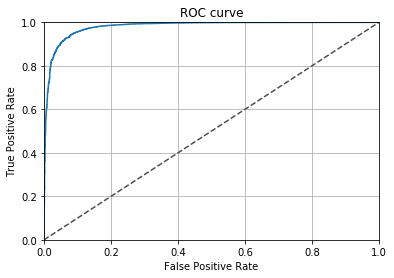

In [59]:
classifier.draw_roc_curve(X_test_vectors, y_test)

测试集上效果不错，auc达到了0.9807

### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).

尝试对SVM，Random Forest，和Xgboost使用grid search和cv进行不同参数的尝试。  
数据量较大，为了提高速度，对训练数据进行下采样。保留全部负样本和相同数目的正样本。

In [13]:
# 负样本的index
neg_index = np.argwhere(np.array(y_train)==0)

In [14]:
# 取出所有负样本
X_train_vectors = np.array(X_train_vectors)
sub_X_train_neg = X_train_vectors[neg_index]

In [15]:
# 取出相同数目的正样本
pos_index = np.argwhere(np.array(y_train)==1)
sub_X_train_pos = X_train_vectors[pos_index][:len(sub_X_train_neg)]

In [16]:
# 拼接正负样本，获取采样结果
sub_X_train = np.concatenate([sub_X_train_neg, sub_X_train_pos])

In [17]:
sub_X_train.shape

(17578, 1, 100)

In [19]:
# 移除多余维度
sub_X_train = sub_X_train.reshape(-1, 100)

In [54]:
# 生成采样内容的标签
sub_y_train = np.array([0]*len(sub_X_train_neg)+[1]*len(sub_X_train_pos))

In [60]:
# 打乱数据顺序
index = list(range(len(sub_y_train)))
np.random.shuffle(index)
sub_X_train = sub_X_train[index]
sub_y_train = sub_y_train[index]

### SVM

待调整参数

In [22]:
svc_param_grid = [{'kernel':['rbf','poly'], 'gamma':[1e-4, 1e-3, 1e-2],'C':[0.1, 1, 10]}]

用grid search cv建立模型

In [23]:
svc_cv = GridSearchCV(SVC(probability=True), param_grid=svc_param_grid, scoring='roc_auc', cv=5, n_jobs=4)

In [107]:
cls_svc_cv = Classifier(svc_cv)

模型训练

In [109]:
cls_svc_cv.train(sub_X_train, sub_y_train)

最佳参数

In [110]:
cls_svc_cv.model.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

模型评估

In [111]:
cls_svc_cv.evaluate(sub_X_train, sub_y_train)

0.9914919922413075

In [112]:
cls_svc_cv.evaluate(X_test_vectors, y_test)

0.9862283758196423

0.9862277022764085

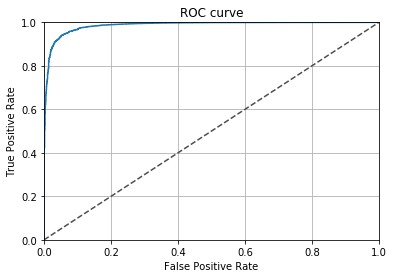

In [113]:
cls_svc_cv.draw_roc_curve(X_test_vectors, y_test)

最终结果比调整前略好一些，最佳参数在范围边界，但是训练速度很慢，就不再做调整了

### Random Forest

In [66]:
rf_param_grid = {'n_estimators':[30, 60, 90], 'max_depth':[5, 10, 15]}
rf_cv = GridSearchCV(RandomForestClassifier(random_state=16), param_grid=rf_param_grid, scoring='roc_auc', cv=5, n_jobs=2)

In [67]:
cls_rf_cv = Classifier(rf_cv)

In [68]:
cls_rf_cv.train(sub_X_train, sub_y_train)

In [69]:
cls_rf_cv.model.best_params_

{'max_depth': 15, 'n_estimators': 90}

In [70]:
cls_rf_cv.evaluate(sub_X_train, sub_y_train)

0.999008719111117

In [71]:
cls_rf_cv.evaluate(X_test_vectors, y_test)

0.9600399521898058

0.9600399521898058

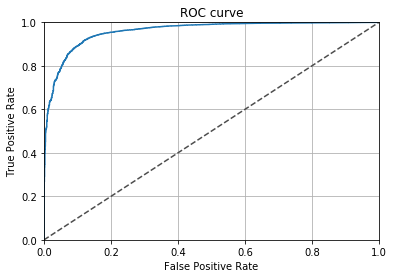

In [72]:
cls_rf_cv.draw_roc_curve(X_test_vectors, y_test)

结果比SVM稍差，参数选取落在边界，可以再加大对应参数进行一轮调整。

best parameters: {'max_depth': 60, 'n_estimators': 270}
train score: 0.9999999999999999
test score: 0.9641986924999135


0.9641986924999135

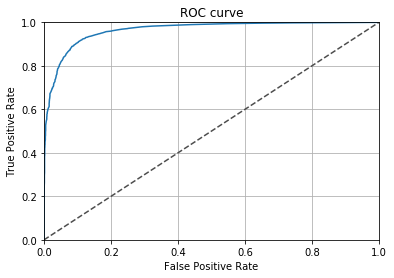

In [81]:
rf_param_grid = {'n_estimators':[90, 180, 270], 'max_depth':[15, 30, 60]}
rf_cv = GridSearchCV(RandomForestClassifier(random_state=16), param_grid=rf_param_grid, scoring='roc_auc', cv=5, n_jobs=4)
cls_rf_cv = Classifier(rf_cv)
cls_rf_cv.train(sub_X_train, sub_y_train)
print("best parameters:", cls_rf_cv.model.best_params_)
print("train score:", cls_rf_cv.evaluate(sub_X_train, sub_y_train))
print("test score:", cls_rf_cv.evaluate(X_test_vectors, y_test))
cls_rf_cv.draw_roc_curve(X_test_vectors, y_test)

效果略有提高，在训练集达到了0.9999，参数依然落在边界，可见树的深度越大，棵数越多，随机森林的效果越好，但是需要注意过拟合的问题以及面向测试集的训练。

### XGBoost

best parameters: {'gamma': 0.2, 'max_depth': 7, 'n_estimators': 100}
train score: 1.0
test score: 0.982404087144161


0.982404087144161

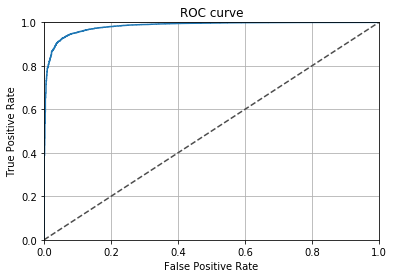

In [86]:
xgb_param_grid = {'max_depth':[3, 5, 7], 'n_estimators':[10,50,100], 'gamma':[0.1,0.2,0.5]}
xgb_cv = GridSearchCV(XGBClassifier(scoring='roc_auc', n_jobs=-1), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, n_jobs=3)
cls_xgb_cv = Classifier(xgb_cv)
cls_xgb_cv.train(sub_X_train, sub_y_train)
print("best parameters:", cls_xgb_cv.model.best_params_)
print("train score:", cls_xgb_cv.evaluate(sub_X_train, sub_y_train))
print("test score:", cls_xgb_cv.evaluate(np.array(X_test_vectors), y_test))
cls_xgb_cv.draw_roc_curve(X_test_vectors, y_test)

弱学习器数目和树的最大深度应该和随机森林一样，取值越大模型越复杂，效果也就越好。gamma取0.2时取得最佳结果。

### 总结

从上面的调整过程可以看到，SVM和xgboost更为适合本数据，在测试集上的效果在98%以上，而随机森林第二次调整后在训练集上得分已经达到了0.9999，测试集却依然在0.96上下，过拟合比其他两个模型更明显，再增加树的棵数和最大深度应该会使其更严重，可能需要调整其他参数以提高其泛化能力。xgboost的效果非常好，在完美拟合训练数据的同时还能在测试数据上达到0.9824的效果。

### Reference
能否在keras的model.add中添加sklearn的SVM: https://tieba.baidu.com/p/6079823608?traceid=  
parallelize-pandas-apply: https://stackoverflow.com/questions/39284989/parallelize-pandas-apply  
Tandem LSTM-SVM Approach for Sentiment Analysis: http://ceur-ws.org/Vol-1749/paper_030.pdf  
带你全面认识自然语言处理三大特征抽取器（CNN/RNN/TF）: https://www.jiqizhixin.com/articles/2019-02-22-9  
文本向量化: https://blog.csdn.net/ZJL0105/article/details/82316056